### Installing Libraries

In [1]:
!pip install -q geopy
!pip install -q geopandas
!pip install -q gensim
!pip install -q nltk

### Importing Libraries

In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from geopy.geocoders import Nominatim
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine

### Loading the dataset

In [4]:
df = pd.read_csv("/Users/mac/Downloads/clearbit_dataset_discovered_companies.csv", low_memory=False)

### 1. Do basic analysis of the dataset using descriptive stats.

In [5]:
df

,id,name,legalname,domain,domainaliases,site_phonenumbers,site_emailaddresses,tags,category_sector,category_industrygroup,...,emailprovider,type,ticker,phone,tech,techcategories,parent_domain,ultimateparent_domain,indexedat,created_at
0,ac725f51-30dc-45c5-844f-8317152a393e,V Search,NaN,vsearch.co.in,[],[],[],[Human Resources],Industrials,Commercial & Professional Services,...,False,private,NaN,NaN,[godaddy_nameserver],[web_hosting],NaN,NaN,2021-08-05T11:20:41.603Z,5/7/2021
1,9428b9d0-4ed0-46b3-b85f-afa3f4f32bd0,NaN,NaN,avsnews.co.in,[],[],[],[],NaN,NaN,...,False,personal,NaN,NaN,"[godaddy_nameserver, google_adsense, wordpress...","[web_hosting, advertising, content_management_...",NaN,NaN,2021-08-05T13:27:37.909Z,5/7/2021
2,883a4827-80e3-424f-8969-12b94be16b47,Techno5,NaN,techno5.in,[],[+91 79 0662 8586],[info@techno5.in],[],NaN,NaN,...,False,private,NaN,NaN,"[godaddy_nameserver, wordpress, asp_net, googl...","[web_hosting, content_management_system, progr...",NaN,NaN,2021-08-05T14:11:18.273Z,5/7/2021
3,f4d5636b-1286-4e7d-abe8-70a1729cadfd,Digital Compound,NaN,digitalcompound.in,[],[+91 79 0748 8830],[mail@digitalcompound.in],[],NaN,NaN,...,False,private,NaN,NaN,"[wordpress, nginx, facebook_connect, hubspot, ...","[content_management_system, web_servers, authe...",NaN,NaN,2021-08-05T15:01:21.384Z,5/7/2021
4,e08dde17-3089-4179-8d58-b7e6245ef5b1,NaN,NaN,meranews24x7.in,[],[],[],[],NaN,NaN,...,False,personal,NaN,NaN,[namecheap_dns],[dns],NaN,NaN,2021-06-21T18:31:27.352Z,5/7/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33381,0a64baed-c453-4d97-82e4-cd8a2b12c436,We Dzin - India,NaN,we-dzin.com,[],[],[],[Architecture],Industrials,Commercial & Professional Services,...,False,private,NaN,NaN,[nginx],[web_servers],NaN,NaN,2021-06-23T01:19:08.382Z,6/23/2021
33382,9a20e96e-7421-4d4c-bf79-9ab1e11206ea,Craftbrain Media,NaN,craftbrain.in,[],[+91 79 8053 0036],[],[Information Technology & Services],Information Technology,Software & Services,...,False,private,NaN,NaN,"[cloud_flare, wordpress, gravity_forms]","[dns, content_management_system, form_builder]",NaN,NaN,2021-06-23T02:11:27.980Z,6/23/2021
33383,df7059c1-771e-48f2-8e47-54b81d947a1f,Onliine Grocery Store - Best Rice and Wheat Store,NaN,smartreads.in,[],[],[],[],NaN,NaN,...,False,private,NaN,NaN,"[wordpress, woo_commerce]","[content_management_system, ecommerce]",NaN,NaN,2021-06-23T04:51:27.855Z,6/23/2021
33384,6b7d81bc-5bdd-4137-90dc-08c37c2d651c,NaN,NaN,capitalfortunes.com,[],"[+91 40 6603 8300, +91 80 2559 4661]","[connect@capitalfortunes.com, siddharth@capita...",[],NaN,NaN,...,False,private,NaN,NaN,"[microsoft_exchange_online, outlook, microsoft...","[email_hosting_service, productivity, content_...",NaN,NaN,2021-07-24T13:51:47.237Z,6/23/2021


### Droping Non-related columns

In [6]:
df = df.drop(['legalname', 'geo_streetnumber', 'geo_streetname', 'geo_subpremise', 'identifiers_usein', 'phone', 
              'metrics_raised', 'metrics_alexausrank', 'metrics_marketcap', 'annualrevenue', 'fiscalyearend', 
              'facebook_handle', 'crunchbase_handle', 'ticker', 'parent_domain', 'ultimateparent_domain'], axis=1)


### Replacing `'[]'` with `'NaN'`

In [7]:
df.replace('[]', np.NaN, inplace=True)

In [8]:
df = df.drop(['domainaliases'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33386 entries, 0 to 33385
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       33386 non-null  object 
 1   name                     22695 non-null  object 
 2   domain                   33386 non-null  object 
 3   site_phonenumbers        9829 non-null   object 
 4   site_emailaddresses      8820 non-null   object 
 5   tags                     7042 non-null   object 
 6   category_sector          6927 non-null   object 
 7   category_industrygroup   6927 non-null   object 
 8   category_industry        6927 non-null   object 
 9   category_subindustry     6927 non-null   object 
 10  category_siccode         5179 non-null   float64
 11  category_naicscode       5633 non-null   float64
 12  foundedyear              2230 non-null   float64
 13  timezone                 33386 non-null  object 
 14  utcoffset             

### 2. Which domains are famous among companies (in/com). Also create plot.

In [10]:
df['domain_extension'] = df['domain'].str.split('.').str[-1]
df['domain_extension']

0         in
1         in
2         in
3         in
4         in
        ... 
33381    com
33382     in
33383     in
33384    com
33385     in
Name: domain_extension, Length: 33386, dtype: object

In [11]:
df_domain_extension = df[df['domain_extension'].notnull()]
extension_counts = df_domain_extension['domain_extension'].value_counts()
extension_counts = extension_counts[:5] # Top 5 extensions
extension_counts

domain_extension
in     27749
com     4968
org      189
net       98
co        97
Name: count, dtype: int64

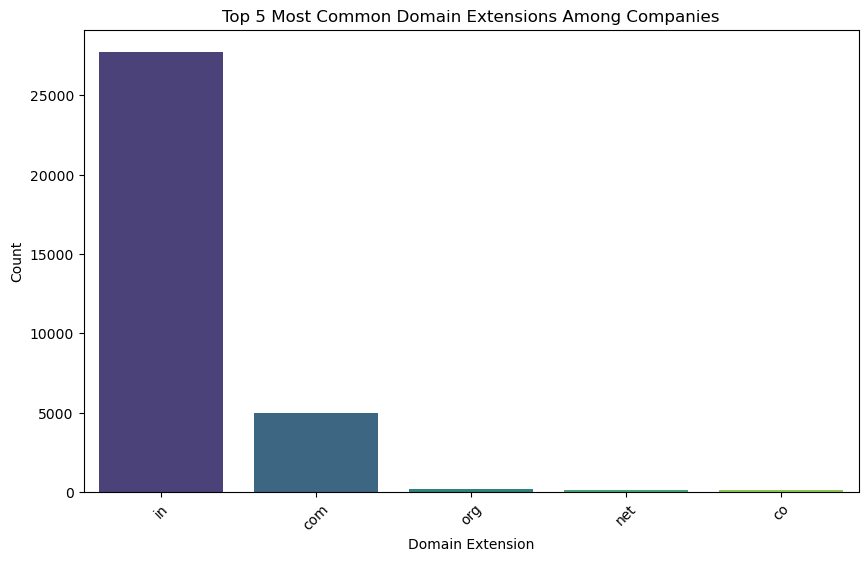

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=extension_counts.index, y=extension_counts.values, palette='viridis')
plt.title('Top 5 Most Common Domain Extensions Among Companies')
plt.xlabel('Domain Extension')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 3. Categorise companies based on their names and domain names. Like service based companies, blog, fintech etc.

In [13]:
def categorize_company(row):
    # Define the categories and their corresponding lists
    categories = {
        'information_technology': ['web', 'tech', 'IT', 'Technologies', 'technology', 'data', 'software', 'network', 'programming', 'code', 'cybersecurity', 'development', 'application', 'database', 'cloud', 'AI', 'machinelearning', 'analytics', 'Python', 'Java', 'C++', 'coding', 'ITservices', 'digital', 'automation', 'techsupport', 'ITconsulting'],
        'media': ['media', 'advertising', 'news', 'akhabaar', 'press', 'magazine', 'TV', 'radio', 'broadcasting', 'journalist', 'publication', 'journalism', 'socialmedia', 'editor', 'reporter', 'newsroom', 'mediaindustry', 'mediaproduction', 'mediaagency', 'mediaoutlet', 'mediaplatform'],
        'education': ['college', 'class', 'classes', 'institute', 'academy', '.edu', '.ac', 'skool', 'university', 'school', 'learning', 'academic', 'study', 'curriculum', 'training', 'course', 'teacher', 'student', 'degree', 'diploma', 'educationalinstitution', 'onlinelearning', 'e-learning', 'educationalresources', 'educationaltechnology', 'teaching'],
        'healthcare': ['health', 'wellness', 'clinic', 'dr', 'diagnostic', 'ayurved', 'medical', 'hospital', 'patient', 'treatment', 'therapy', 'healthcareservices', 'healthcareprovider', 'medicalcenter', 'healthcareindustry', 'healthcaretechnology', 'healthcaresolutions', 'medicalequipment', 'healthcareprofessionals'],
        'fashion': ['fashion', 'style', 'trend', 'designer', 'clothing', 'apparel', 'boutique', 'runway', 'fashionista', 'fashionindustry', 'fashiondesign', 'fashionbrand', 'fashionshow', 'fashionblog', 'fashionaccessories', 'fashioninfluencer', 'fashionmodel', 'hautecouture', 'fashionmagazine'],
        'tour_and_travel': ['tour', 'travel', 'hotel', 'trip', 'vacation', 'destination', 'tourism', 'journey', 'adventure', 'booking', 'travelagency', 'travelguide', 'travelplanner', 'traveldestination', 'travelpackage', 'holiday', 'explorer', 'sightseeing', 'travelexperience', 'travelblog', 'traveltips'],
        'electrical': ['camera', 'cctv', 'electric', 'electrical', 'electronic', 'device', 'gadget', 'appliance', 'equipment', 'electricalengineering', 'electricalcontractor', 'electricalservices', 'electricalequipment', 'electricalsystem', 'electricalwiring', 'electrician', 'electricalsafety'],
        'jewellery': ['jewelry', 'jewellers', 'jewel', 'gemstone', 'gold', 'silver', 'diamond', 'accessory', 'bracelet', 'necklace', 'jewelrystore', 'jewelrydesign', 'jewelrymaker', 'finejewelry', 'luxuryjewelry', 'customjewelry', 'fashionjewelry', 'jewelrycollection', 'jewelrybrand', 'jewelryrepair'],
        'architecture': ['real', 'estate', 'infra', 'builders', 'architect', 'construction', 'building', 'design', 'structure', 'blueprint', 'urban', 'architecturefirm', 'architecturaldesign', 'architectureservices', 'constructioncompany', 'buildingcontractor', 'realestatedeveloper', 'propertydevelopment'],
        'food': ['cake', 'food', 'eat', 'recipe', 'cafe', 'market', 'mart', 'restaurant', 'cuisine', 'chef', 'dining', 'cooking', 'gourmet', 'foodindustry', 'foodblog', 'fooddelivery', 'foodservice', 'foodcatering', 'foodmenu', 'foodtruck', 'foodbusiness', 'foodproduction', 'culinary', 'culinaryarts'],
        'entertainment': ['game', 'gamer', 'studio', 'bollywood', 'fun', 'entertainment', 'movie', 'music', 'theater', 'show', 'concert', 'performance', 'gaming', 'entertainmentindustry', 'entertainmentcenter', 'entertainmentvenue', 'entertainmentnews', 'entertainmentblog', 'entertainmentevent', 'movietheater', 'musicfestival'],
        'textile': ['mill', 'fabric', 'material', 'garment', 'weaving', 'thread', 'yarn', 'textile', 'textileindustry', 'textilemanufacturing', 'textiledesign', 'textilecompany', 'textilemachinery', 'textileproducts', 'textiletrade', 'textilebusiness', 'textileart', 'textileprinting', 'textileexporter'],
        'sporting_goods': ['sport', 'sportinggoods', 'equipment', 'gear', 'athlete', 'fitness', 'exercise', 'gym', 'sportsequipment', 'sportsgear', 'sportsapparel', 'sportinggoodsstore', 'sportsbrand', 'sportsindustry', 'sportsequipmentmanufacturer', 'sportswear', 'sportsaccessories', 'sportsclothing', 'sportsshop'],
        'fintech': ['pay', 'money', 'bank', 'finance', 'budget', 'stock', 'trading', 'invest', 'investing', 'financial', 'payment', 'banking', 'financialservices', 'financialtechnology', 'fintech', 'fintechcompany', 'fintechsolutions', 'fintechindustry', 'onlinepayment', 'digitalpayment', 'financialinstitution', 'financialadvisor', 'financialplanning', 'investmentmanagement'],
        'services': ['care', 'solution', 'solutions', 'consultancy', 'associates', 'support', 'assistance', 'advisory', 'consulting', 'partnership', 'collaboration', 'service', 'professionalservices', 'businessservices', 'consultingservices', 'advisoryservices', 'clientservices', 'customerservice', 'serviceprovider']
    }

    company_name = row['name'] if pd.notnull(row['name']) else row['domain']
    
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword.lower() in company_name.lower():
                return category
    
    return None

df['category'] = df.apply(categorize_company, axis=1)
df_categorized = df[df['category'].notnull()]
df_categorized[['name', 'domain', 'category']].reset_index(inplace=True, drop=True)
df_categorized[['name', 'domain', 'category']]

,name,domain,category
1,NaN,avsnews.co.in,media
2,Techno5,techno5.in,information_technology
3,Digital Compound,digitalcompound.in,information_technology
4,NaN,meranews24x7.in,media
5,Aay Kay Infraestate,aaykayinfraestate.com,architecture
...,...,...,...
33378,Jet Express Cargo,dhlcourierchennai.co.in,media
33380,Nidram,nidram.in,healthcare
33382,Craftbrain Media,craftbrain.in,information_technology
33383,Onliine Grocery Store - Best Rice and Wheat Store,smartreads.in,food


### 4. A list of companies and their 10 digit phone numbers.

In [14]:
# Function to extract the 10-digit phone number from a string
def extract_phone_number(phone_str):
    if isinstance(phone_str, str):
        phone_str = phone_str.replace('[', '').replace(']', '').replace(' ', '')
        for i in range(len(phone_str) - 1, -1, -1):
            if phone_str[i].isdigit() and len(phone_str[i:]) >= 10:
                return phone_str[i:i+10]
    return None

# Function to extract domain name if company is null
def extract_domain_name(row):
    if pd.isnull(row['name']):
        domain_parts = row['domain'].split('.')
        if len(domain_parts) >= 2:
            return domain_parts[0]
    return None

In [15]:
df['phone_number'] = df['site_phonenumbers'].apply(lambda x: extract_phone_number(str(x)))

df['company_name'] = df.apply(lambda row: row['name'] if not pd.isnull(row['name']) else extract_domain_name(row), axis=1)

df_company_with_phone = df[['id', 'company_name', 'phone_number']].copy()
df_company_with_phone = df_company_with_phone.dropna(subset=['id', 'company_name', 'phone_number'])
df_company_with_phone.reset_index(inplace=True, drop=True)
df_company_with_phone

,id,company_name,phone_number
0,883a4827-80e3-424f-8969-12b94be16b47,Techno5,7906628586
1,f4d5636b-1286-4e7d-abe8-70a1729cadfd,Digital Compound,7907488830
2,a2641370-51e5-4d7e-8d86-cd15516b4674,Aay Kay Infraestate,5224044778
3,5114327b-efde-4c2b-a091-3b9b572c8800,Vintage Fashions,8006645555
4,765bec07-9a24-4e74-9a45-d48da1551fd1,handlair,7042898442
...,...,...,...
9824,69374485-e5b6-4fc7-889b-e3f0b87cab93,IntegerHouse,9995388784
9825,f4c77ff7-ef86-42b3-a748-1f2af54b66b9,Jet Express Cargo,4442059930
9826,52089756-c969-4899-9c47-a0274804ddfd,Nidram,9011036289
9827,9a20e96e-7421-4d4c-bf79-9ab1e11206ea,Craftbrain Media,7980530036


### 5. Which email names are popular among companies(admin/info) etc. Also plot it.

In [16]:
email_names = []
for emails_str in df['site_emailaddresses']:
    if isinstance(emails_str, str):
        emails_list = emails_str.replace('[', '').replace(']', '').split(', ')
        for email in emails_list:
            email_names.append(email.split('@')[0])

email_name_counts = pd.Series(email_names).value_counts()
email_name_counts = email_name_counts[:5]
email_name_counts

info       3802
support    1151
contact     871
sales       545
hello       326
Name: count, dtype: int64

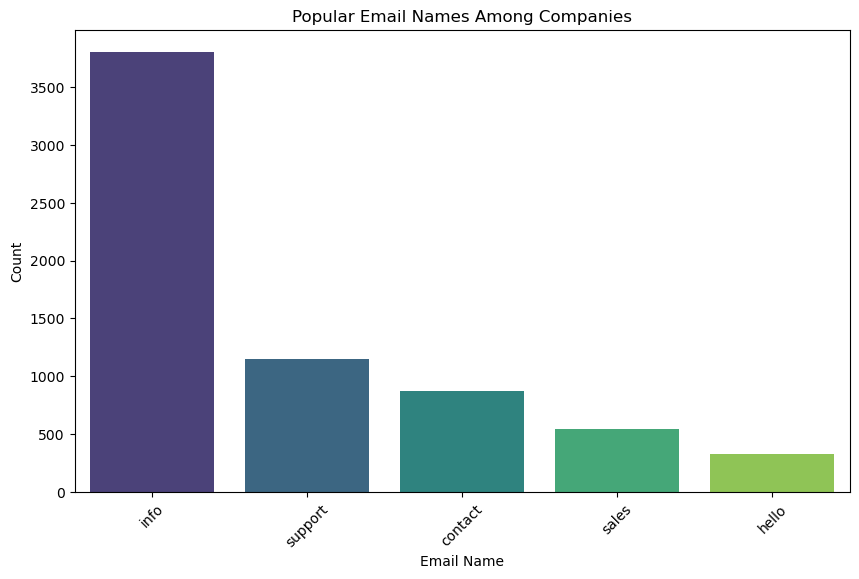

In [17]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=email_name_counts.index, y=email_name_counts.values, palette='viridis')
plt.xlabel('Email Name')
plt.ylabel('Count')
plt.title('Popular Email Names Among Companies')
plt.xticks(rotation=45)
plt.show()

### 6. Categorise companies in different sectors with plots.

In [18]:
df_sector = df[df['category_sector'].notnull()]

In [19]:
sector_counts = df_sector['category_sector'].value_counts()
sector_counts

category_sector
Consumer Discretionary        2821
Information Technology        1496
Industrials                   1310
Health Care                    406
Financials                     386
Materials                      205
Consumer Staples               171
Utilities                       75
Telecommunication Services      29
Energy                          28
Name: count, dtype: int64

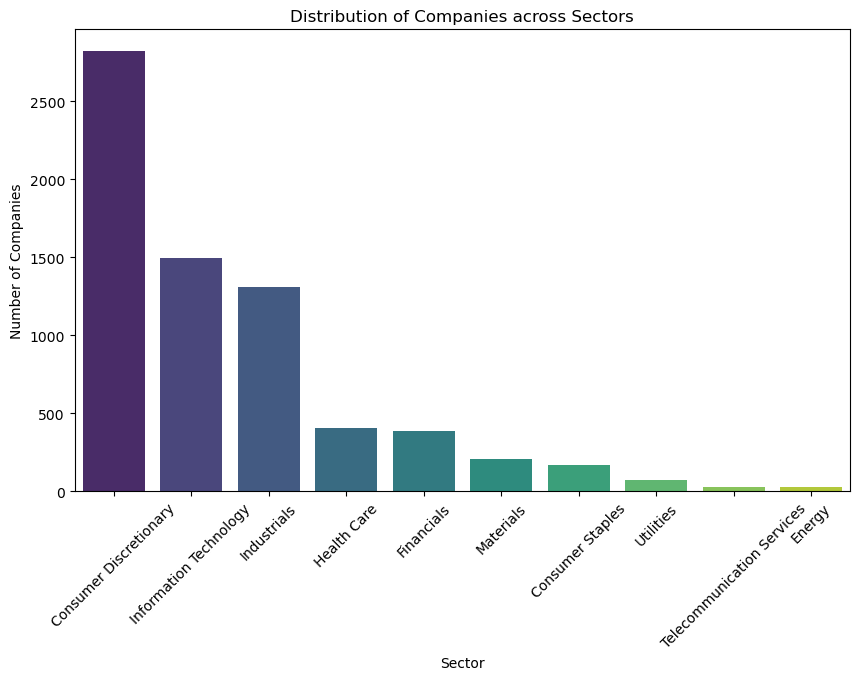

In [20]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values, palette='viridis')
plt.title('Distribution of Companies across Sectors')
plt.xlabel('Sector')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.show()

### 7. Plot companies on India’s map based on their location.

In [54]:
df_new = df.copy()

In [65]:
df_new['geo_combined'] = df_new['geo_lat'].astype(str) + ', ' + df_new['geo_lng'].astype(str)

In [66]:
df_new['geo_combined'].value_counts().head(10)
# therefore the default value is 20.593684, 78.96288 with freq 27651.

geo_combined
20.593684, 78.96288       27651
19.0759837, 72.8776559      105
12.9715987, 77.5945627       94
28.6139391, 77.2090212       90
28.7040592, 77.1024902       58
17.385044, 78.486671         45
18.5204303, 73.8567437       36
28.4594965, 77.0266383       34
13.0826802, 80.2707184       31
19.7514798, 75.7138884       26
Name: count, dtype: int64

In [82]:
df_new = df_new[df_new['geo_combined']!="20.593684, 78.96288"]

In [83]:
df_new

,id,name,domain,site_phonenumbers,site_emailaddresses,tags,category_sector,category_industrygroup,category_industry,category_subindustry,...,type,tech,techcategories,indexedat,created_at,domain_extension,category,phone_number,company_name,geo_combined
5,a2641370-51e5-4d7e-8d86-cd15516b4674,Aay Kay Infraestate,aaykayinfraestate.com,"[+91 94150 24149, +91 522 404 4778]",[info@aaykayinfraestate.com],[Real Estate],Financials,Real Estate,Real Estate,Real Estate,...,private,"[godaddy_nameserver, asp_net, facebook_social_...","[web_hosting, programming_framework, social_sh...",2021-07-29T04:47:21.013Z,5/7/2021,com,architecture,5224044778,Aay Kay Infraestate,"26.8551032, 80.9449942"
9,af70e5ec-1503-4393-bbad-c31eb2329d43,DAN.COM,analogwebmedia.com,NaN,NaN,[Information Technology & Services],Information Technology,Software & Services,Internet Software & Services,Internet Software & Services,...,private,"[trustpilot, ruby_on_rails, google_remarketing...","[user_engagement, programming_framework, adver...",2021-06-22T00:40:48.048Z,5/8/2021,com,None,None,DAN.COM,"28.585037, 77.3116409"
10,dbefb8b6-2258-4b3c-9ee5-99c0722e7500,Tour Travel 360,tourtravel360.com,NaN,NaN,[Travel & Leisure],Consumer Discretionary,Consumer Services,"Hotels, Restaurants & Leisure","Hotels, Restaurants & Leisure",...,private,NaN,NaN,2021-06-22T03:10:34.939Z,5/8/2021,com,tour_and_travel,None,Tour Travel 360,"28.6134872, 76.9800836"
11,044e8f09-3ede-4f27-bccb-b814ceb982cb,NaN,elevatelabs.tech,NaN,NaN,[E-Learning],Information Technology,Software & Services,Internet Software & Services,Internet Software & Services,...,private,NaN,NaN,2021-07-25T14:38:40.084Z,5/8/2021,tech,information_technology,None,elevatelabs,"12.9298689, 77.6848366"
15,37dc71b7-632f-4c3e-82e6-67205a1d96f7,Hotel Veenu International - India,hotelveenuinternational.com,NaN,NaN,[Travel & Leisure],Consumer Discretionary,Consumer Services,"Hotels, Restaurants & Leisure","Hotels, Restaurants & Leisure",...,private,NaN,NaN,2021-06-22T16:40:30.710Z,5/8/2021,com,tour_and_travel,None,Hotel Veenu International - India,"12.8707145, 74.846945"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33353,b99a7991-821d-4848-9d22-06b105969895,Velocita Technologies,velocitatech.com,"[+91 80590 66666, +91 99153 84328]",[info@velocitatech.com],[Information Technology & Services],Information Technology,Software & Services,Internet Software & Services,Internet Software & Services,...,private,"[wordpress, apache]","[content_management_system, web_servers]",2021-08-05T08:19:18.638Z,6/21/2021,com,information_technology,9915384328,Velocita Technologies,"30.6707702, 76.8596769"
33375,56020645-f055-4b49-bc72-81f3e5cb3adc,nineMotion Systems,ninemotion.com,NaN,NaN,[Information Technology & Services],Information Technology,Software & Services,Internet Software & Services,Internet Software & Services,...,private,NaN,NaN,2021-06-22T19:55:53.086Z,6/22/2021,com,None,None,nineMotion Systems,"12.9715987, 77.5945627"
33376,69374485-e5b6-4fc7-889b-e3f0b87cab93,IntegerHouse,integerhouse.com,[+91 99953 88784],"[info@integerhouse.com, careers@integerhouse.com]",NaN,NaN,NaN,NaN,NaN,...,private,"[godaddy_nameserver, apache]","[web_hosting, web_servers]",2021-07-24T10:14:58.096Z,6/22/2021,com,None,9995388784,IntegerHouse,"8.6148215, 76.8893907"
33381,0a64baed-c453-4d97-82e4-cd8a2b12c436,We Dzin - India,we-dzin.com,NaN,NaN,[Architecture],Industrials,Commercial & Professional Services,Professional Services,Architecture,...,private,[nginx],[web_servers],2021-06-23T01:19:08.382Z,6/23/2021,com,None,None,We Dzin - India,"12.942708, 77.5602804"


In [84]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
india = world[world.name == 'India']
indian_companies = df_new[df_new['geo_countrycode'] == 'IN']

gdf = gpd.GeoDataFrame(indian_companies, geometry=gpd.points_from_xy(indian_companies['geo_lng'], indian_companies['geo_lat']))

/var/folders/3t/gg1853g50kj9b5xn92nypzmc0000gn/T/ipykernel_5489/166181840.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


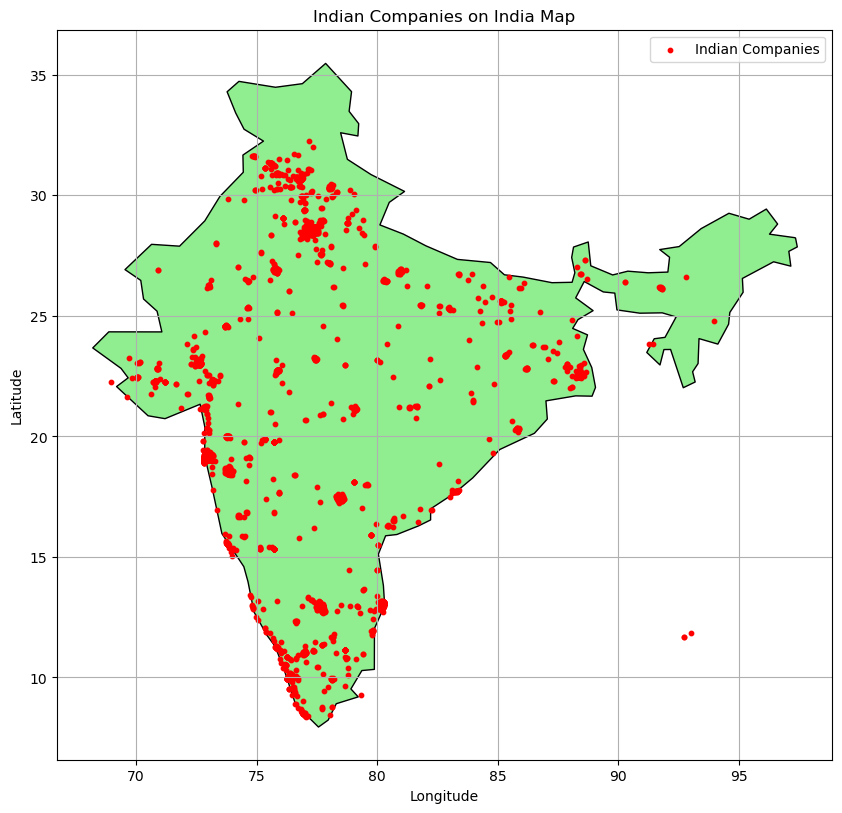

In [85]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
india.plot(ax=ax, color='lightgreen', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=10, label='Indian Companies')
ax.set_title('Indian Companies on India Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


### 8. Which state and cities are leading in number of companies.

### Cities with leading companies

In [23]:
df_city = df[df['geo_city'].notnull()]
city_counts = df_city['geo_city'].value_counts()
city_counts = city_counts[:10]
city_counts

geo_city
Bengaluru    591
New Delhi    590
Mumbai       560
Chennai      287
Hyderabad    279
Pune         239
Kolkata      196
Ahmedabad    195
Gurugram     168
Noida        160
Name: count, dtype: int64

### States with leading companies

In [24]:
df_state = df[df['geo_state'].notnull()]
state_counts = df_state['geo_state'].value_counts()
state_counts = state_counts[:10]
state_counts

geo_state
Maharashtra      1175
Delhi             766
Karnataka         657
Tamil Nadu        461
Gujarat           422
Uttar Pradesh     390
Telangana         343
Haryana           281
West Bengal       235
Rajasthan         197
Name: count, dtype: int64

### 9. Plot companies according to size of their revenue.

In [25]:
df_revenue = df[df['estimatedannualrevenue'].notnull()]
company_counts = df_revenue['estimatedannualrevenue'].value_counts()
company_counts


estimatedannualrevenue
$0-$1M         3740
$1M-$10M       1804
$10M-$50M       724
$50M-$100M      282
$100M-$250M      18
$250M-$500M       4
$1B-$10B          3
$500M-$1B         3
$10B+             2
Name: count, dtype: int64

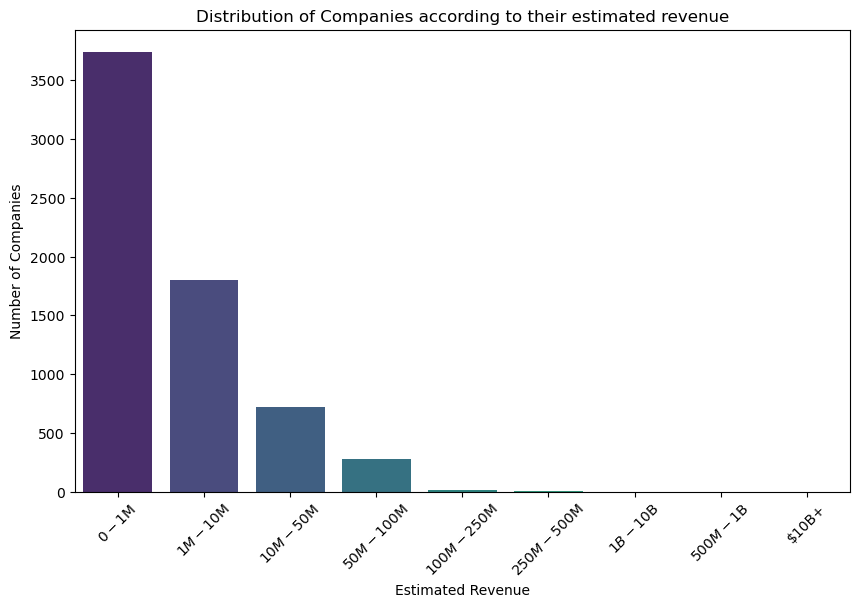

In [26]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=company_counts.index, y=company_counts.values, palette='viridis')
plt.title('Distribution of Companies according to their estimated revenue')
plt.xlabel('Estimated Revenue')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.show()


### 10. Finally select useful features that could be used to classify similarity among companies and create embeddings for them.

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec

In [119]:
selected_features = ['company_name', 'tags', 'category_sector', 'category_industrygroup', 'category_industry', 'category_subindustry', 'category_siccode', 'techcategories']
df_selected = df[selected_features].fillna('')
# df_selected_without_exclude = df_selected[selected_features].drop(columns=['company_name'])
df_selected['combined_features'] = df_selected.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)


In [120]:
df_selected['combined_features'] = df_selected['combined_features'].apply(lambda x: x.replace('[', '').replace(']', ''))


In [121]:
features = df_selected['combined_features'].tolist()

In [129]:
df_selected['combined_features']

0        V Search Human Resources Industrials Commercia...
1        avsnews       web_hosting, advertising, conten...
2        Techno5       web_hosting, content_management_...
3        Digital Compound       content_management_syst...
4                                   meranews24x7       dns
                               ...                        
33381    We Dzin - India Architecture Industrials Comme...
33382    Craftbrain Media Information Technology & Serv...
33383    Onliine Grocery Store - Best Rice and Wheat St...
33384    capitalfortunes       email_hosting_service, p...
33385                     vegan quickiee       web_hosting
Name: combined_features, Length: 33386, dtype: object

In [ ]:
# Using BOW and TF-IDF approachs first

### BOW Approach

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [122]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(features)

In [123]:
cos_sim_matrix = cosine_similarity(X)

In [125]:
# Function to calculate similarity between two companies
def get_similarity(company1, company2):
    idx1 = df_selected.index[df_selected['company_name'] == company1][0]
    idx2 = df_selected.index[df_selected['company_name'] == company2][0]
    return [idx1, idx2]

In [144]:
company1 = input("Enter the first company name: ")
company2 = input("Enter the second company name: ")

idx1, idx2 = get_similarity(company1, company2)
similarity_score = cos_sim_matrix[idx1, idx2]
print(f"Similarity between Company A and Company B using BOW: {similarity_score}")

Enter the first company name: Quantumclasses
Enter the second company name: Indian Institute of Materials Management
Similarity between Company A and Company B using BOW: 0.8006407690254358


### TF-IDF Approach

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_selected['combined_features'])

In [126]:
similarity_matrix = cosine_similarity(tfidf_matrix)

In [145]:
company1 = input("Enter the first company name: ")
company2 = input("Enter the second company name: ")

idx1, idx2 = get_similarity(company1, company2)
similarity_score = similarity_matrix[idx1, idx2]
print(f"Similarity between Company A and Company B using IF-IDF: {similarity_score}")

Enter the first company name: Quantumclasses
Enter the second company name: Indian Institute of Materials Management
Similarity between Company A and Company B using IF-IDF: 0.656932595074561


In [140]:
# As both BOW and IF-IDF Approach are not working well for all the cases, therefore using Word2Vec Approach

### Word2Vec

In [133]:
tokenized_features = [word_tokenize(sentence) for sentence in features]


In [134]:
word2vec_model = Word2Vec(tokenized_features, vector_size=100, window=5)

In [135]:
# Function to generate embeddings for a combined feature
def generate_embedding(combined_features):
    embedding = np.zeros(word2vec_model.vector_size)
    for word in combined_features.split():
        if word in word2vec_model.wv:
            embedding += word2vec_model.wv[word]
    return embedding

df_selected['embeddings'] = df_selected['combined_features'].apply(generate_embedding)

In [147]:
df_selected

,company_name,tags,category_sector,category_industrygroup,category_industry,category_subindustry,category_siccode,techcategories,combined_features,embeddings
0,V Search,[Human Resources],Industrials,Commercial & Professional Services,Professional Services,Human Resource & Employment Services,73.0,[web_hosting],V Search Human Resources Industrials Commercia...,"[-4.003268147353083, -2.4877385199069977, -4.4..."
1,avsnews,,,,,,,"[web_hosting, advertising, content_management_...","avsnews web_hosting, advertising, conten...","[0.6053704023361206, -0.4773295223712921, -0.0..."
2,Techno5,,,,,,,"[web_hosting, content_management_system, progr...","Techno5 web_hosting, content_management_...","[0.575690746307373, -0.30671876668930054, -0.3..."
3,Digital Compound,,,,,,,"[content_management_system, web_servers, authe...",Digital Compound content_management_syst...,"[0.6640743911266327, -0.0281219482421875, -0.1..."
4,meranews24x7,,,,,,,[dns],meranews24x7 dns,"[0.5726373791694641, -0.3116339445114136, 0.14..."
...,...,...,...,...,...,...,...,...,...,...
33381,We Dzin - India,[Architecture],Industrials,Commercial & Professional Services,Professional Services,Architecture,87.0,[web_servers],We Dzin - India Architecture Industrials Comme...,"[-1.1756996475160122, -2.1549552977085114, -0...."
33382,Craftbrain Media,[Information Technology & Services],Information Technology,Software & Services,Internet Software & Services,Internet Software & Services,48.0,"[dns, content_management_system, form_builder]",Craftbrain Media Information Technology & Serv...,"[-2.9943286180496216, -5.9112670654430985, 6.2..."
33383,Onliine Grocery Store - Best Rice and Wheat Store,,,,,,,"[content_management_system, ecommerce]",Onliine Grocery Store - Best Rice and Wheat St...,"[0.5237984352279454, 0.9002966582775116, 0.937..."
33384,capitalfortunes,,,,,,,"[email_hosting_service, productivity, content_...","capitalfortunes email_hosting_service, p...","[0.08779866993427277, -0.24177688360214233, 0...."


In [146]:
company_name_1 = input("Enter the first company name: ")
company_name_2 = input("Enter the second company name: ")

try:
    comp1_embeddings = df_selected.loc[df_selected['company_name'] == f'{company_name_1}', 'embeddings'].values[0]
    comp2_embeddings = df_selected.loc[df_selected['company_name'] == f'{company_name_2}', 'embeddings'].values[0]
    similarity_score = 1-cosine(comp1_embeddings, comp2_embeddings)
    print(f"\nSimilarity Score between the {company_name_1} and {company_name_2}:", similarity_score)
except Exception as e:
    print("\nAn error occurred, Company name does not exists")

Enter the first company name: Quantumclasses
Enter the second company name: Indian Institute of Materials Management

Similarity Score between the Quantumclasses and Indian Institute of Materials Management: 0.9787008276179546
